In [2]:
# Inicializar una lista para almacenar los resultados
results = []

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol, 'current_time'].min()

    # Definir el evento y la duración
    if pd.isna(fill_time):
        event = 0
        duration = (group['current_time'].max() - first_enroll_time).total_seconds() / 60  # En minutos
    else:
        event = 1
        duration = (fill_time - first_enroll_time).total_seconds() / 60  # En minutos
    
    # Agregar los resultados a la lista
    results.append({'nrc': nrc, 'first_enroll_time': first_enroll_time, 'fill_time': fill_time, 
                    'duration': duration, 'event': event})

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Mostrar el resultado
result_df.head()

NameError: name 'transactions_df' is not defined

## Instalar libreria del modelo

In [ ]:
 %pip install scikit-survival


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Modelo base

Concordance Index: 0.5681362298775554


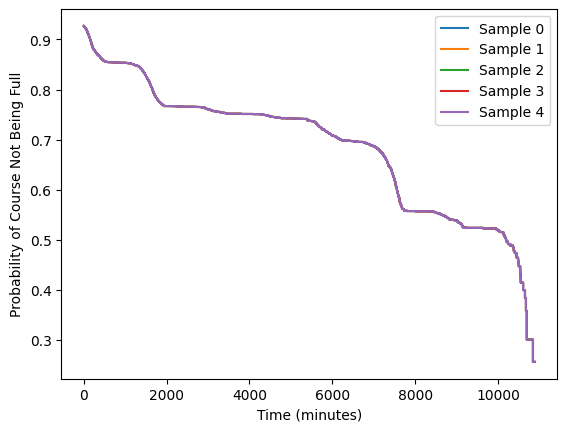

In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# Asumiendo que tu DataFrame se llama result_df y ya está preparado con las columnas ['nrc', 'first_enroll_time', 'fill_time', 'duration', 'event']

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear una matriz de características simple (X) solo para pasar al modelo
# Aquí se usa una columna de unos como placeholder
encoder = OneHotEncoder()
X = encoder.fit_transform(result_df[['nrc']])  # Asegúrate de ajustar según las columnas que deseas usar

# Paso 3: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 4: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 5: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')

# Paso 6: (Opcional) Visualizar algunas funciones de supervivencia
pred_surv = model.predict_survival_function(X)
for i, surv_func in enumerate(pred_surv[:5]):  # Visualizar las primeras 5 funciones de supervivencia
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Sample {i}")
plt.ylabel("Probability of Course Not Being Full")
plt.xlabel("Time (minutes)")
plt.legend()
plt.show()


# Modelo con Dia de la semana

In [ ]:
# Identificar NRCs en transactions_df que no están en initial_df
nrcs_initial = initial_df['nrc'].unique()
nrcs_transactions = transactions_df['nrc'].unique()
missing_nrcs = set(nrcs_transactions) - set(nrcs_initial)

print("NRCs en transactions_df que faltan en initial_df:", missing_nrcs)

# Filtrar transactions_df para eliminar los NRCs que no están en initial_df
transactions_df = transactions_df[~transactions_df['nrc'].isin(missing_nrcs)]

# Confirmar la eliminación
print("NRCs después de filtrar:", transactions_df['nrc'].unique())

NRCs en transactions_df que faltan en initial_df: set()
NRCs después de filtrar: [39342 65779 52118 ... 67741 73250 66209]


In [ ]:
# Inicializar una lista para almacenar los resultados
results = []

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol, 'current_time'].min()

    # Definir el evento y la duración
    if pd.isna(fill_time):
        event = 0
        duration = (group['current_time'].max() - first_enroll_time).total_seconds() / 60  # En minutos
    else:
        event = 1
        duration = (fill_time - first_enroll_time).total_seconds() / 60  # En minutos
    

    # Extraer días de la semana desde initial_df
    schedule = initial_df.loc[initial_df['nrc'] == nrc, 'schedules'].values[0]
    days_of_week = set(day for data in schedule for day in ['l', 'm', 'i', 'j', 'v', 's', 'd'] if data.get(day))
    
    # Agregar los resultados a la lista
    results.append({'nrc': nrc, 'first_enroll_time': first_enroll_time, 'fill_time': fill_time, 
                    'duration': duration, 'event': event, 'days_of_week': days_of_week})


# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)


# Mostrar el resultado
result_df.head()

,nrc,first_enroll_time,fill_time,duration,event,days_of_week
0,10004,2024-07-22 08:02:51,NaT,1770.300000,0,"{i, v}"
1,10005,2024-07-18 12:06:32,NaT,3200.783333,0,{l}
2,10006,2024-07-18 18:24:09,NaT,7114.400000,0,{}
3,10016,2024-07-18 11:16:45,NaT,7257.350000,0,"{i, l}"
4,10017,2024-07-18 10:33:04,NaT,8982.616667,0,"{i, v}"


Concordance Index: 0.6102615187676335


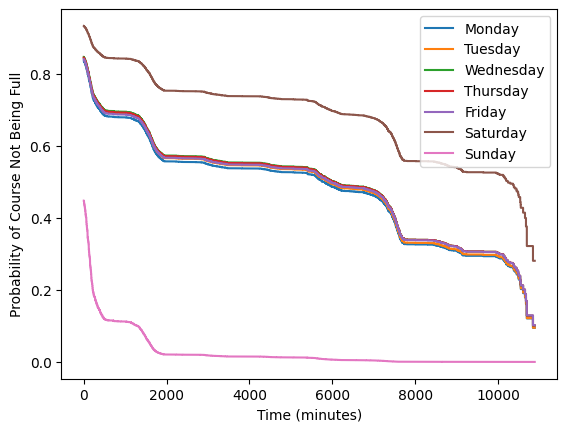

In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# Asumiendo que tu DataFrame se llama result_df y ya está preparado con las columnas ['nrc', 'first_enroll_time', 'fill_time', 'duration', 'event']

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Codificar los días de la semana como variables categóricas
days_expanded = result_df['days_of_week'].apply(lambda x: list(x)).explode()
days_one_hot = pd.get_dummies(days_expanded).groupby(level=0).sum()

# Añadir estas columnas codificadas al DataFrame original
result_df = result_df.join(days_one_hot)

# Crear la matriz de características (X) utilizando los días de la semana codificados
X = result_df[['l', 'm', 'i', 'j', 'v', 's', 'd']].values


# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 3: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 4: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 5: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')

# Paso 6: Crear un DataFrame por cada día de la semana y calcular el promedio de las funciones de supervivencia

days = ['l', 'm', 'i', 'j', 'v', 's', 'd']
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Iterar sobre cada día de la semana y filtrar los datos correspondientes
for i, day in enumerate(days):
    # Filtrar los datos donde el día correspondiente es 1 (indica que el curso se imparte ese día)
    day_df = result_df[result_df[day] == 1]
    
    if not day_df.empty:  # Verificar si el DataFrame no está vacío
        # Crear las características (X) y variable objetivo (y) para este día
        X_day = day_df[['l', 'm', 'i', 'j', 'v', 's', 'd']].values
        y_day = day_df[['event', 'duration']].to_records(index=False)
        
        # Predecir la función de supervivencia para los datos de este día
        pred_surv_day = model.predict_survival_function(X_day)
        
        # Calcular el promedio de las funciones de supervivencia
        avg_surv_prob = np.mean([surv_func.y for surv_func in pred_surv_day], axis=0)
        
        # Dibujar la curva de supervivencia promedio para este día
        plt.step(pred_surv_day[0].x, avg_surv_prob, where="post", label=day_labels[i])

# Mostrar las curvas promediadas para cada día de la semana
plt.ylabel("Probability of Course Not Being Full")
plt.xlabel("Time (minutes)")
plt.legend(loc="best")
plt.show()

In [ ]:
pred_surv

array([StepFunction(x=array([0.00000000e+00, 2.00000000e+00, 3.63333333e+00, ...,
              1.08751167e+04, 1.08753833e+04, 1.08865500e+04]), y=array([0.92711896, 0.92699136, 0.92686374, ..., 0.25541278, 0.25541278,
              0.25541278]), a=1.0, b=0.0)                                                                                                ,
       StepFunction(x=array([0.00000000e+00, 2.00000000e+00, 3.63333333e+00, ...,
              1.08751167e+04, 1.08753833e+04, 1.08865500e+04]), y=array([0.92711825, 0.92699065, 0.92686303, ..., 0.25540925, 0.25540925,
              0.25540925]), a=1.0, b=0.0)                                                                                                ,
       StepFunction(x=array([0.00000000e+00, 2.00000000e+00, 3.63333333e+00, ...,
              1.08751167e+04, 1.08753833e+04, 1.08865500e+04]), y=array([0.92711754, 0.92698993, 0.92686232, ..., 0.25540572, 0.25540572,
              0.25540572]), a=1.0, b=0.0)                     

In [ ]:
X

array([[0, 0, 1, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

## Modelo con nivel

In [ ]:
# Inicializar una lista para almacenar los resultados
results = []

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol, 'current_time'].min()

    # Definir el evento y la duración
    if pd.isna(fill_time):
        event = 0
        duration = (group['current_time'].max() - first_enroll_time).total_seconds() / 60  # En minutos
    else:
        event = 1
        duration = (fill_time - first_enroll_time).total_seconds() / 60  # En minutos
    

    # Extraer el nivel del curso del campo "course"
    course = initial_df.loc[initial_df['nrc'] == nrc, 'course'].values[0]
    course_level = int(str(course)[0])  # Tomar el primer número como el nivel del curso
    
    # Agregar los resultados a la lista
    results.append({'nrc': nrc, 'first_enroll_time': first_enroll_time, 'fill_time': fill_time, 
                    'duration': duration, 'event': event, 'course_level': course_level})

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)


# Mostrar el resultado
result_df.head()

,nrc,first_enroll_time,fill_time,duration,event,course_level
0,10004,2024-07-22 08:02:51,NaT,1770.300000,0,2
1,10005,2024-07-18 12:06:32,NaT,3200.783333,0,4
2,10006,2024-07-18 18:24:09,NaT,7114.400000,0,4
3,10016,2024-07-18 11:16:45,NaT,7257.350000,0,4
4,10017,2024-07-18 10:33:04,NaT,8982.616667,0,4


Concordance Index: 0.5572535260008293


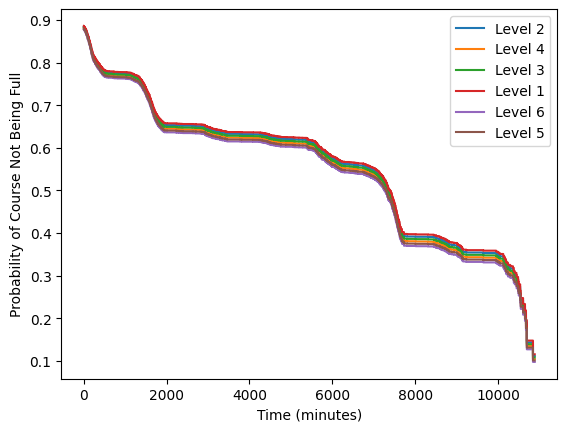

In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Crear la matriz de características (X) utilizando únicamente el nivel del curso
X = result_df[['course_level']].values

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 3: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 4: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')

# Paso 5: Crear un DataFrame por cada nivel de curso y calcular el promedio de las funciones de supervivencia
levels = result_df['course_level'].unique()
level_labels = [f"Level {level}" for level in levels]

# Iterar sobre cada nivel de curso y filtrar los datos correspondientes
for level in levels:
    # Filtrar los datos donde el curso tiene el nivel correspondiente
    level_df = result_df[result_df['course_level'] == level]
    
    if not level_df.empty:  # Verificar si el DataFrame no está vacío
        # Crear las características (X) y variable objetivo (y) para este nivel
        X_level = level_df[['course_level']].values
        y_level = level_df[['event', 'duration']].to_records(index=False)
        
        # Predecir la función de supervivencia para los datos de este nivel
        pred_surv_level = model.predict_survival_function(X_level)
        
        # Calcular el promedio de las funciones de supervivencia
        avg_surv_prob = np.mean([surv_func.y for surv_func in pred_surv_level], axis=0)
        
        # Dibujar la curva de supervivencia promedio para este nivel
        plt.step(pred_surv_level[0].x, avg_surv_prob, where="post", label=f"Level {level}")

# Mostrar las curvas promediadas para cada nivel de curso
plt.ylabel("Probability of Course Not Being Full")
plt.xlabel("Time (minutes)")
plt.legend(loc="best")
plt.show()

## Class

In [ ]:
# Inicializar una lista para almacenar los resultados
results = []

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol, 'current_time'].min()

    # Definir el evento y la duración
    if pd.isna(fill_time):
        event = 0
        duration = (group['current_time'].max() - first_enroll_time).total_seconds() / 60  # En minutos
    else:
        event = 1
        duration = (fill_time - first_enroll_time).total_seconds() / 60  # En minutos
    

    # Extraer el valor de la columna "class" desde initial_df
    course_class = initial_df.loc[initial_df['nrc'] == nrc, 'class'].values[0]
    
    # Agregar los resultados a la lista
    results.append({'nrc': nrc, 'first_enroll_time': first_enroll_time, 'fill_time': fill_time, 
                    'duration': duration, 'event': event, 'course_class': course_class})

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)


# Mostrar el resultado
result_df.head()

,nrc,first_enroll_time,fill_time,duration,event,course_class
0,10004,2024-07-22 08:02:51,NaT,1770.300000,0,MATE
1,10005,2024-07-18 12:06:32,NaT,3200.783333,0,MATE
2,10006,2024-07-18 18:24:09,NaT,7114.400000,0,MATE
3,10016,2024-07-18 11:16:45,NaT,7257.350000,0,IIND
4,10017,2024-07-18 10:33:04,NaT,8982.616667,0,IIND


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.08882e-17): result may not be accurate.
  delta = solve(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.19075e-18): result may not be accurate.
  delta = solve(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=7.77326e-17): result may not be accurate.
  delta = solve(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.52731e-17): result may not be accurate.
  delta = solve(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning:

Concordance Index: 0.7900912351890254


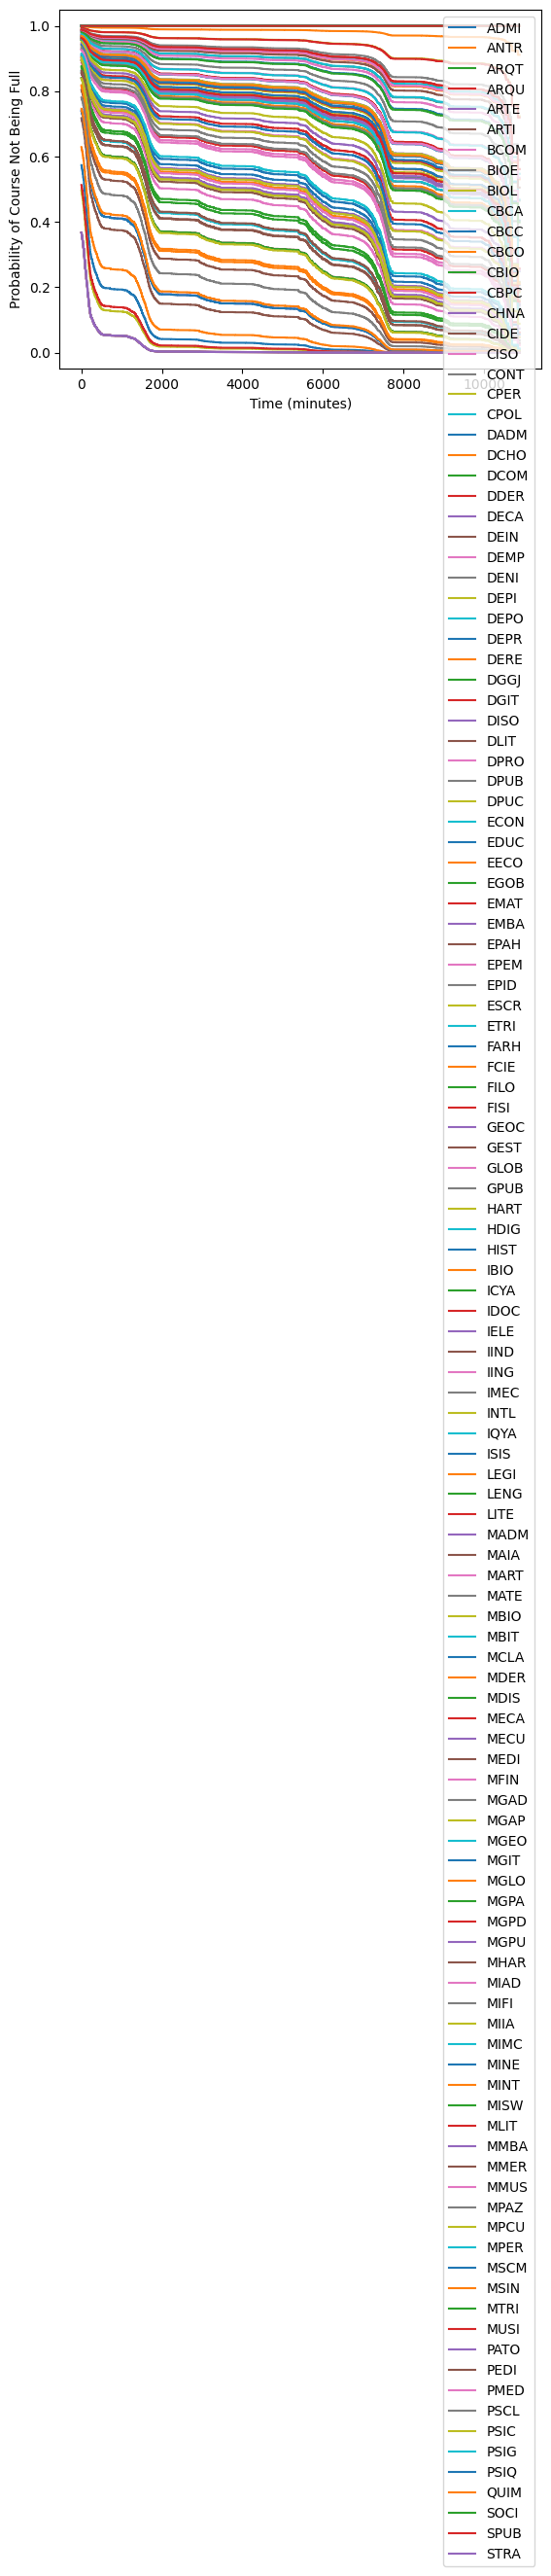

In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Codificar la columna 'class' usando One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)  # Cambiar 'sparse' por 'sparse_output'
class_encoded = encoder.fit_transform(result_df[['course_class']])

# Crear la matriz de características (X) utilizando la codificación de 'class'
X = class_encoded

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 3: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 4: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')

# Paso 5: Crear un DataFrame por cada valor de 'class' y calcular el promedio de las funciones de supervivencia
classes = result_df['course_class'].unique()
class_labels = encoder.categories_[0]  # Obtener las etiquetas de las clases codificadas

# Iterar sobre cada clase y filtrar los datos correspondientes
for i, class_value in enumerate(classes):
    # Filtrar los datos donde la clase es el valor correspondiente
    class_df = result_df[result_df['course_class'] == class_value]
    
    if not class_df.empty:  # Verificar si el DataFrame no está vacío
        # Crear las características (X) y variable objetivo (y) para esta clase
        X_class = encoder.transform(class_df[['course_class']])
        y_class = class_df[['event', 'duration']].to_records(index=False)
        
        # Predecir la función de supervivencia para los datos de esta clase
        pred_surv_class = model.predict_survival_function(X_class)
        
        # Calcular el promedio de las funciones de supervivencia
        avg_surv_prob = np.mean([surv_func.y for surv_func in pred_surv_class], axis=0)
        
        # Dibujar la curva de supervivencia promedio para esta clase
        plt.step(pred_surv_class[0].x, avg_surv_prob, where="post", label=class_labels[i])

# Mostrar las curvas promediadas para cada clase
plt.ylabel("Probability of Course Not Being Full")
plt.xlabel("Time (minutes)")
plt.legend(loc="best")
plt.show()

## Ciclo

In [ ]:
# Inicializar una lista para almacenar los resultados
results = []

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol, 'current_time'].min()

    # Definir el evento y la duración
    if pd.isna(fill_time):
        event = 0
        duration = (group['current_time'].max() - first_enroll_time).total_seconds() / 60  # En minutos
    else:
        event = 1
        duration = (fill_time - first_enroll_time).total_seconds() / 60  # En minutos
    

    # Extraer el valor de la columna "ptrmdesc" desde initial_df
    ptrmdesc = initial_df.loc[initial_df['nrc'] == nrc, 'ptrmdesc'].values[0]
    
    # Agregar los resultados a la lista
    results.append({'nrc': nrc, 'first_enroll_time': first_enroll_time, 'fill_time': fill_time, 
                    'duration': duration, 'event': event, 'ptrmdesc': ptrmdesc})

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)


# Mostrar el resultado
result_df.head()

,nrc,first_enroll_time,fill_time,duration,event,ptrmdesc
0,10004,2024-07-22 08:02:51,NaT,1770.300000,0,PERIODO 202420 - 16 SEMANAS
1,10005,2024-07-18 12:06:32,NaT,3200.783333,0,PERIODO 202420 - 16 SEMANAS
2,10006,2024-07-18 18:24:09,NaT,7114.400000,0,PERIODO 202420 - 16 SEMANAS
3,10016,2024-07-18 11:16:45,NaT,7257.350000,0,PERIODO 202420 - 16 SEMANAS
4,10017,2024-07-18 10:33:04,NaT,8982.616667,0,PERIODO 202420 - 16 SEMANAS


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=8.80134e-17): result may not be accurate.
  delta = solve(


Concordance Index: 0.6496760549739966


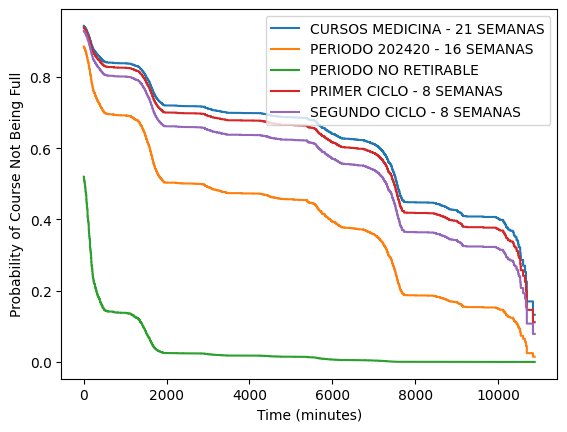

In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Codificar la columna 'ptrmdesc' usando One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
ptrmdesc_encoded = encoder.fit_transform(result_df[['ptrmdesc']])

# Crear la matriz de características (X) utilizando la codificación de 'ptrmdesc'
X = ptrmdesc_encoded

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 3: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 4: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')

# Paso 5: Crear un DataFrame por cada valor de 'ptrmdesc' y calcular el promedio de las funciones de supervivencia
ptrmdescs = result_df['ptrmdesc'].unique()
ptrmdesc_labels = encoder.categories_[0]  # Obtener las etiquetas de los períodos codificados

# Iterar sobre cada 'ptrmdesc' y filtrar los datos correspondientes
for i, ptrmdesc_value in enumerate(ptrmdescs):
    # Filtrar los datos donde el 'ptrmdesc' es el valor correspondiente
    ptrmdesc_df = result_df[result_df['ptrmdesc'] == ptrmdesc_value]
    
    if not ptrmdesc_df.empty:  # Verificar si el DataFrame no está vacío
        # Crear las características (X) y variable objetivo (y) para este 'ptrmdesc'
        X_ptrmdesc = encoder.transform(ptrmdesc_df[['ptrmdesc']])
        y_ptrmdesc = ptrmdesc_df[['event', 'duration']].to_records(index=False)
        
        # Predecir la función de supervivencia para los datos de este 'ptrmdesc'
        pred_surv_ptrmdesc = model.predict_survival_function(X_ptrmdesc)
        
        # Calcular el promedio de las funciones de supervivencia
        avg_surv_prob = np.mean([surv_func.y for surv_func in pred_surv_ptrmdesc], axis=0)
        
        # Dibujar la curva de supervivencia promedio para este 'ptrmdesc'
        plt.step(pred_surv_ptrmdesc[0].x, avg_surv_prob, where="post", label=ptrmdesc_labels[i])

# Mostrar las curvas promediadas para cada período ('ptrmdesc')
plt.ylabel("Probability of Course Not Being Full")
plt.xlabel("Time (minutes)")
plt.legend(loc="best")
plt.show()



# Periodo no retirable:    Tesis, paractica social...

## Hora

In [ ]:
import matplotlib.pyplot as plt

# Función para crear intervalos de 30 minutos y asignar 1 o 0 en función de todos los horarios del curso
def create_time_bins(schedules):
    bins = np.zeros(48)  # 48 intervalos de 30 minutos en un día (24 horas * 2)
    
    # Iterar sobre todas las entradas en la lista de horarios
    for schedule in schedules:
        if schedule['time_ini'] is None or schedule['time_fin'] is None:
            # Si no hay tiempo de inicio o fin, ignorar esta entrada
            continue

        # Convertir time_ini y time_fin a minutos
        time_ini = int(schedule['time_ini'][:2]) * 60 + int(schedule['time_ini'][2:])  # Convertir a minutos
        time_fin = int(schedule['time_fin'][:2]) * 60 + int(schedule['time_fin'][2:])  # Convertir a minutos
        
        # Marcar los intervalos de 30 minutos correspondientes
        for i in range(48):  # Cada intervalo representa 30 minutos
            interval_start = i * 30
            interval_end = (i + 1) * 30
            # Comprobar si el curso se solapa con el bin en cualquier punto
            if not (time_fin <= interval_start or time_ini >= interval_end):
                bins[i] = 1
    return bins

# Inicializar una lista para almacenar los resultados
results = []

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol, 'current_time'].min()

    # Definir el evento y la duración
    if pd.isna(fill_time):
        event = 0
        duration = (group['current_time'].max() - first_enroll_time).total_seconds() / 60  # En minutos
    else:
        event = 1
        duration = (fill_time - first_enroll_time).total_seconds() / 60  # En minutos
    
    # Extraer todos los horarios desde initial_df
    schedules = initial_df.loc[initial_df['nrc'] == nrc, 'schedules'].values[0]
    time_bins = create_time_bins(schedules)  # Ahora pasa todos los horarios



    # Agregar los resultados a la lista
    results.append({'nrc': nrc, 'first_enroll_time': first_enroll_time, 'fill_time': fill_time, 
                    'duration': duration, 'event': event, 'time_bins': time_bins})

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Mostrar el resultado
result_df.head()


,nrc,first_enroll_time,fill_time,duration,event,time_bins
0,10004,2024-07-22 08:02:51,NaT,1770.300000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10005,2024-07-18 12:06:32,NaT,3200.783333,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10006,2024-07-18 18:24:09,NaT,7114.400000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10016,2024-07-18 11:16:45,NaT,7257.350000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10017,2024-07-18 10:33:04,NaT,8982.616667,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
#Imprimir un valor de time_bins
result_df['time_bins'].iloc[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Concordance Index: 0.6298137198339973


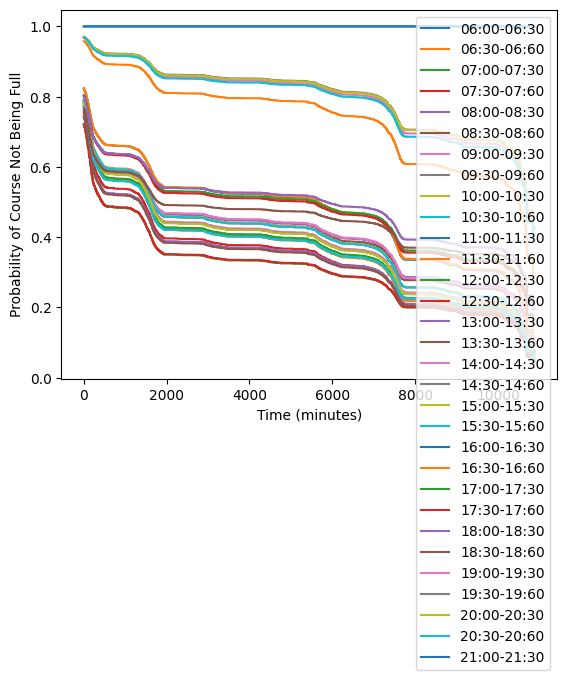

In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)


# Crear etiquetas descriptivas para los intervalos de tiempo (30 minutos cada uno)
interval_labels = [f'{i//2:02}:{(i%2)*30:02}-{(i//2):02}:{((i%2)+1)*30:02}' for i in range(48)]

# Expandir los time_bins y crear un DataFrame con las etiquetas de tiempo
time_bins_expanded = pd.DataFrame(result_df['time_bins'].tolist(), columns=interval_labels)


# Eliminar las columnas que contienen solo ceros
time_bins_expanded = time_bins_expanded.loc[:, (time_bins_expanded != 0).any(axis=0)]

# Añadir estas columnas codificadas al DataFrame original
result_df = result_df.join(time_bins_expanded)

# Crear la matriz de características (X) utilizando los intervalos de tiempo codificados
X = time_bins_expanded.values

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 3: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 4: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')

# Paso 5: Crear un DataFrame por cada intervalo de 30 minutos y calcular el promedio de las funciones de supervivencia
intervals = time_bins_expanded.columns  # Etiquetas de los intervalos de tiempo

# Iterar sobre cada intervalo de 30 minutos y filtrar los datos correspondientes
for i, interval in enumerate(intervals):
    # Filtrar los datos donde el intervalo correspondiente es 1 (indica que el curso se imparte en ese intervalo)
    interval_df = result_df[result_df[interval] == 1]
    
    if not interval_df.empty:  # Verificar si el DataFrame no está vacío
        # Crear las características (X) y variable objetivo (y) para este intervalo
        X_interval = interval_df[intervals].values
        y_interval = interval_df[['event', 'duration']].to_records(index=False)
        
        # Predecir la función de supervivencia para los datos de este intervalo
        pred_surv_interval = model.predict_survival_function(X_interval)
        
        # Calcular el promedio de las funciones de supervivencia
        avg_surv_prob = np.mean([surv_func.y for surv_func in pred_surv_interval], axis=0)
        
        # Dibujar la curva de supervivencia promedio para este intervalo
        plt.step(pred_surv_interval[0].x, avg_surv_prob, where="post", label=interval)

# Mostrar las curvas promediadas para cada intervalo de 30 minutos
plt.ylabel("Probability of Course Not Being Full")
plt.xlabel("Time (minutes)")
plt.legend(loc="best")
plt.show()


# Con todas las Variables (Dia, Hora, Nivel, Facultad)

In [ ]:
#Imprimir un valor de time_bins
result_df['time_bins'].iloc[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Quitar deportes

#Igual ya se quitaban por la fecha


In [ ]:
import pandas as pd
import numpy as np
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Filtrar los deportes (donde course_class sea 'DEPO')
result_df = result_df[result_df['course_class'] != 'DEPO']

# Codificar los días de la semana como variables categóricas
days_expanded = result_df['days_of_week'].apply(lambda x: list(x)).explode()
days_one_hot = pd.get_dummies(days_expanded).groupby(level=0).sum()

# Crear etiquetas descriptivas para los intervalos de tiempo (30 minutos cada uno)
interval_labels = [f'{i//2:02}:{(i%2)*30:02}-{(i//2):02}:{((i%2)+1)*30:02}' for i in range(48)]

# Expandir los time_bins y crear un DataFrame con las etiquetas de tiempo
time_bins_expanded = pd.DataFrame(result_df['time_bins'].tolist(), columns=interval_labels)

# Eliminar las columnas que contienen solo ceros
time_bins_expanded = time_bins_expanded.loc[:, (time_bins_expanded != 0).any(axis=0)]

# Añadir las columnas codificadas al DataFrame original
result_df = result_df.join(days_one_hot)
result_df = result_df.join(time_bins_expanded)



# Convertir las columnas categóricas a tipo 'category'
result_df['course_class'] = result_df['course_class'].astype('category')
result_df['ptrmdesc'] = result_df['ptrmdesc'].astype('category')


# Codificar las variables categóricas ('class', 'ptrmdesc')
encoder_class = OneHotEncoder()  # Cambiado 'sparse_output' por 'sparse'
class_encoded = encoder_class.fit_transform(result_df[['course_class']])

encoder_ptrmdesc = OneHotEncoder()  # Cambiado 'sparse_output' por 'sparse'
ptrmdesc_encoded = encoder_ptrmdesc.fit_transform(result_df[['ptrmdesc']])

# Crear la matriz de características (X) uniendo todas las variables: 
# horas, días de la semana, clase, ciclo, y nivel
X = np.hstack([
    time_bins_expanded.values,       # Hora (intervalos de 30 minutos)
    days_one_hot.values,             # Días de la semana
    class_encoded,                   # Clase (codificada)
    ptrmdesc_encoded,                # Ciclo (codificado)
    result_df[['course_level']].values  # Nivel del curso
])

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)

# Paso 3: Entrenar el modelo de supervivencia
model = CoxPHSurvivalAnalysis()
model.fit(X, y)

# Paso 4: Evaluar el modelo
cindex = concordance_index_censored(y['event'], y['duration'], model.predict(X))
print(f'Concordance Index: {cindex[0]}')



Concordance Index: 0.8085198245632405


In [ ]:
result_df

,nrc,first_enroll_time,fill_time,duration,event,time_bins,days_of_week,course_level,course_class,ptrmdesc,...,16:30-16:60,17:00-17:30,17:30-17:60,18:00-18:30,18:30-18:60,19:00-19:30,19:30-19:60,20:00-20:30,20:30-20:60,21:00-21:30
0,10004,2024-07-22 08:02:51,NaT,1770.300000,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, v}",2,MATE,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10005,2024-07-18 12:06:32,NaT,3200.783333,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{l},4,MATE,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10006,2024-07-18 18:24:09,NaT,7114.400000,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},4,MATE,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10016,2024-07-18 11:16:45,NaT,7257.350000,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, l}",4,IIND,PERIODO 202420 - 16 SEMANAS,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10017,2024-07-18 10:33:04,NaT,8982.616667,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, v}",4,IIND,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,73426,2024-07-18 16:04:58,NaT,8387.833333,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{j},4,MIMC,PERIODO 202420 - 16 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5485,73428,2024-07-18 14:36:43,NaT,9866.583333,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{v},4,MGPU,PRIMER CICLO - 8 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5486,73431,2024-07-18 17:42:48,NaT,6729.833333,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{v},4,MECA,PRIMER CICLO - 8 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5487,73432,2024-07-19 11:58:34,NaT,4354.483333,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{v},4,MECA,SEGUNDO CICLO - 8 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#de los 5000 datos, 3000 nulos


result_df['fill_time'].isna().sum()

3005

---
